# __TicketSwift Extract__: License Data Extraction for Traffic Ticketing System
---
__TicketSwift__ Extract is a feature that utilizes machine learning concepts to extract data from driving licenses for digital traffic ticketing systems. This allows operators to ensure that all relevant information from the driver's license is acquired in an efficient and accurate manner. It also simplifies the process from ticket issuance to resolution—which can be done entirely online—as it allows the seamless entry of data from the operator into the ticketing system.

In [1]:
# Monitor GPU device
!nvidia-smi

Sun Jan  7 17:20:38 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.40       Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:02:00.0 Off |                  N/A |
| N/A    0C    P0    N/A /  N/A |      0MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## __How It Works:__
The system will utilize __YOLOv8__, a model designed for object detection, which will be trained to detect PH driver's licenses _(assuming that the license is captured in the proper orientation)_. Once it detects a license, the system will isolate and crop the image accordingly. __OCR (Optical Character Recognition)__ will then be implemented to detect and extract key information from the license, converting it to machine-readable text.
___

In [23]:
# Import necessary libraries
import os
import glob
import cv2
import easyocr
import pandas as pd
import matplotlib.pyplot as plt

## 1. Prepare custom dataset for annotation and preprocessing 
Preprocess the images (grayscaling, thresholding). Then with Labelmg, __[annotate the data and save the labels in YOLO format](https://www.youtube.com/watch?v=1d7u8wTmA80)__.


In [3]:
source_path = "datasets/license/images/orig"

imgs = [x for x in glob.iglob(f'{source_path}/*')]
imgs

['datasets/license/images/orig\\0.jpg',
 'datasets/license/images/orig\\1.jpg',
 'datasets/license/images/orig\\10.jpg',
 'datasets/license/images/orig\\2.jpg',
 'datasets/license/images/orig\\3.jpg',
 'datasets/license/images/orig\\4.jpg',
 'datasets/license/images/orig\\5.jpg',
 'datasets/license/images/orig\\6.jpg',
 'datasets/license/images/orig\\7.jpg',
 'datasets/license/images/orig\\8.jpg',
 'datasets/license/images/orig\\9.jpg']

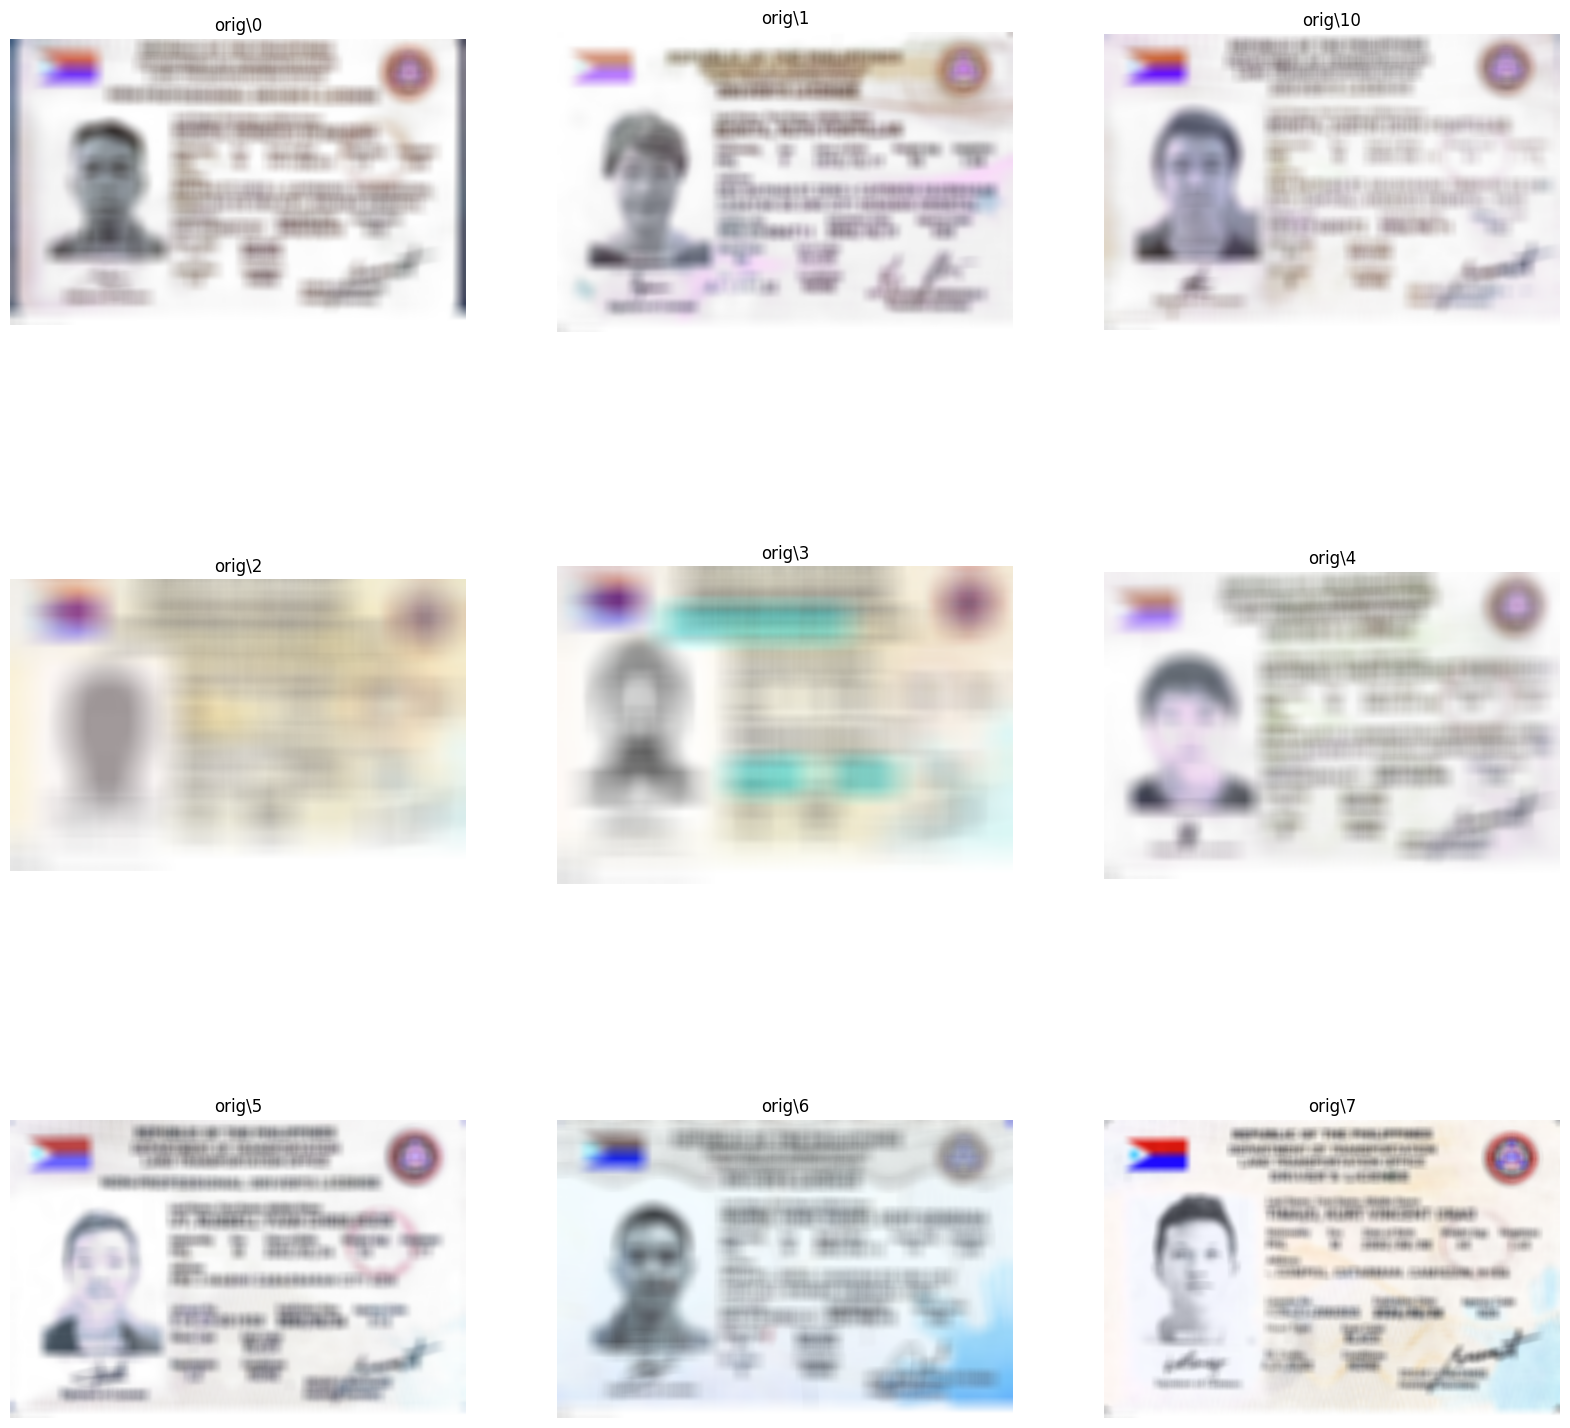

In [4]:
# Original dataset
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.flatten()

for i in range(9):
    img = cv2.imread(imgs[i]) 
    blur_img = cv2.blur(img,(60,60)) 
    axs[i].imshow(blur_img)
    axs[i].axis('off')
    image_id = imgs[i].split('/')[-1].rstrip('.jpg')
    axs[i].set_title(f'{image_id}')
    
plt.show()

In [11]:
# Preprocessing images
count = 0

for x in range(len(imgs)):
    os.chdir(r'D:\Download\FINAL-20240110T053915Z-001\FINAL') 
    img = cv2.imread(imgs[x])
    os.chdir(r'D:\Download\FINAL-20240110T053915Z-001\FINAL\datasets\license\images\preprocess') 
    gs_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thres_img = cv2.threshold(gs_img, 0, 200, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    cv2.imwrite(f'{count}.jpg', thres_img) 
    count += 1
    os.chdir(r'D:\Download\FINAL-20240110T053915Z-001\FINAL')   # for reset

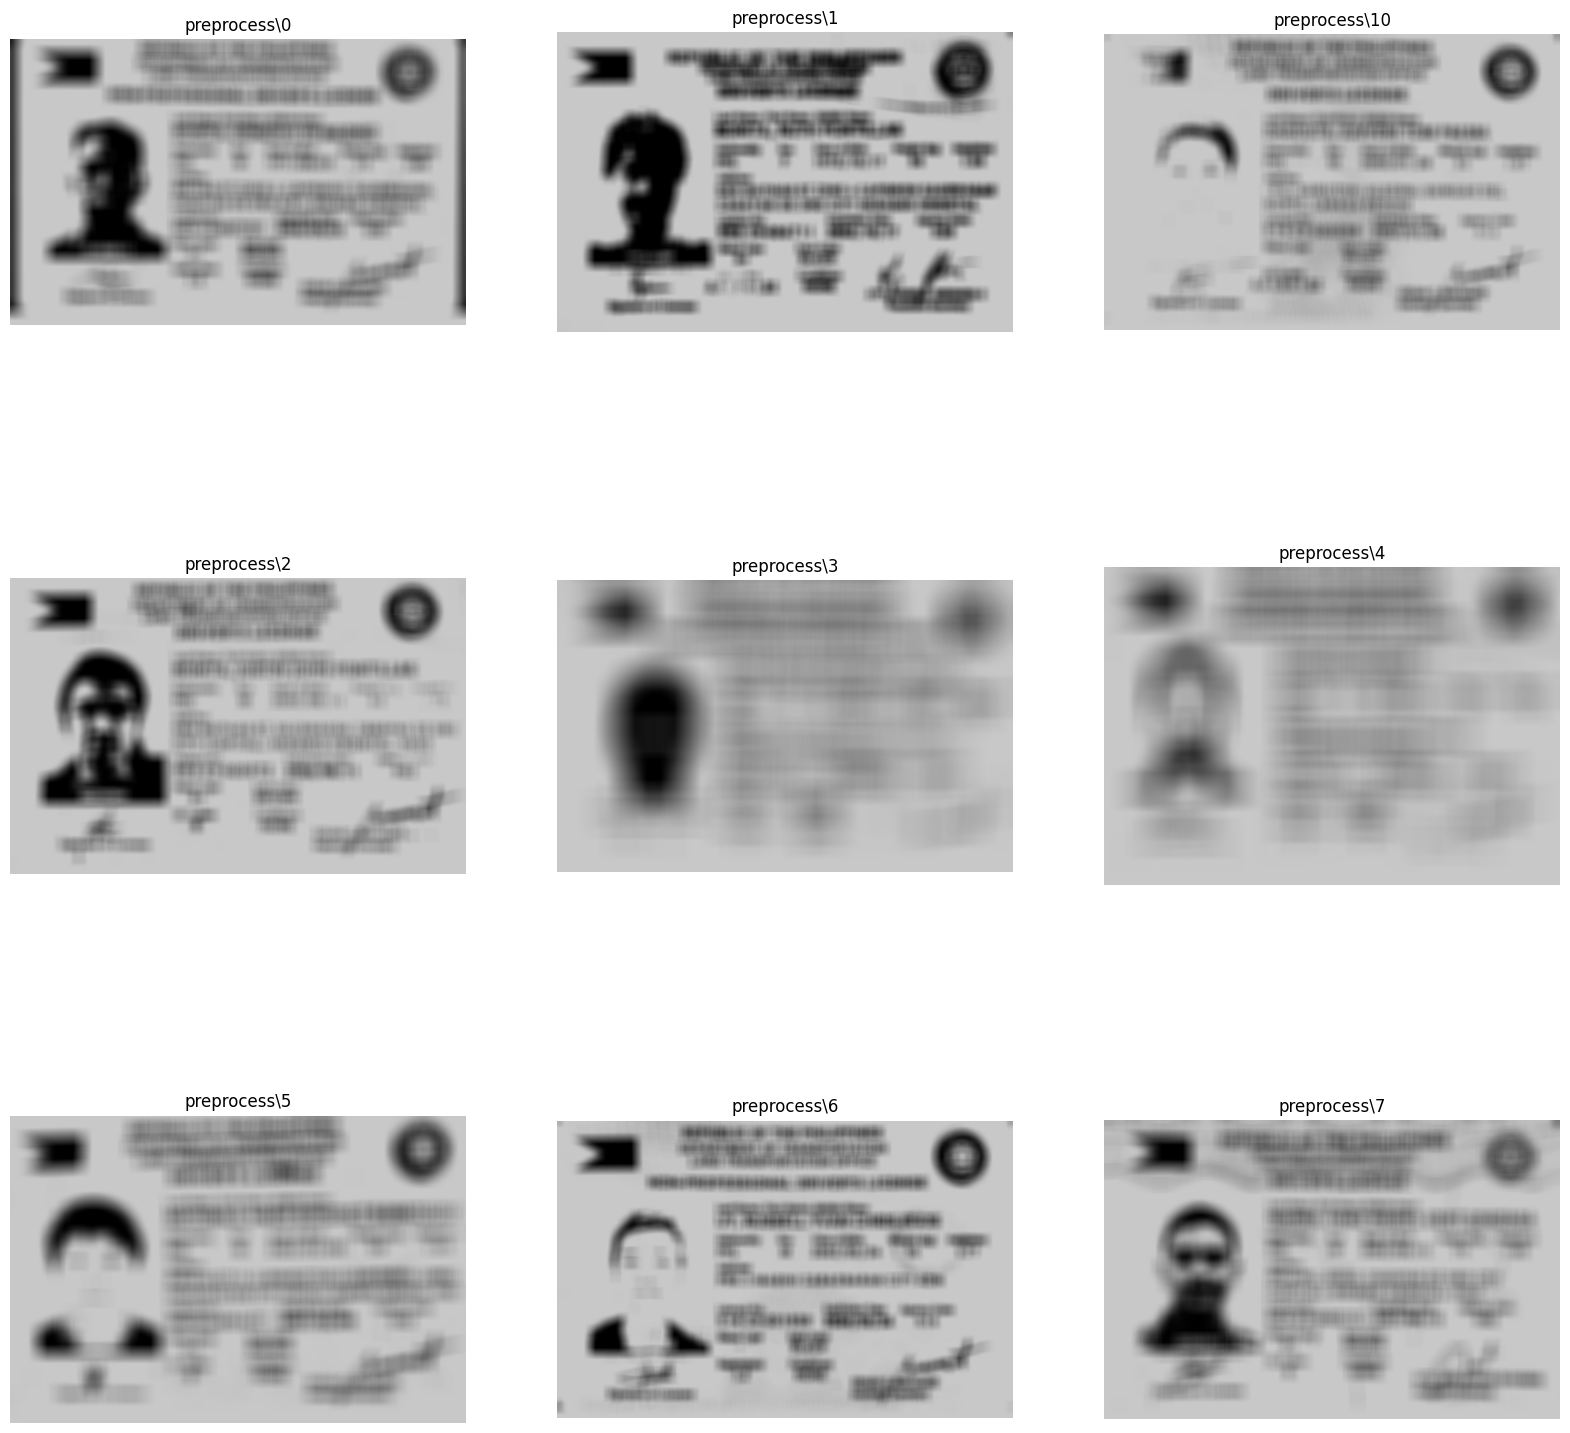

In [12]:
# Preprocessed dataset
source_path = "datasets/license/images/preprocess"
imgs = [x for x in glob.iglob(f'{source_path}/*')]

fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.flatten()

for i in range(9):
    img = cv2.imread(imgs[i]) 
    blur_img = cv2.blur(img,(60,60)) 
    axs[i].imshow(blur_img)
    axs[i].axis('off')
    image_id = imgs[i].split('/')[-1].rstrip('.jpg')
    axs[i].set_title(f'{image_id}')
    
plt.show()

## 2. Select & train YOLOv8 model 
Select pretrained (pre-initialized weights) model for training/fine-tuning. __YOLOv8n__ will be used for this scenario.

In [1]:
# In config.yaml (uncomment below)


# path: D:\Download\FINAL-20240110T053915Z-001\FINAL\datasets\license
# train: images\train
# val: images\val

# names:
#   0: name
#   1: sex
#   2: license
#   3: code

In [ ]:
# Run command for model training (train.py provided by YOLOv8)
!yolo task=detect mode=train model=yolov8n.pt data=config.yaml epochs=50

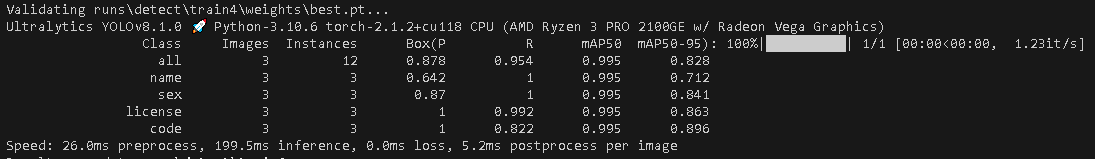

__Results:__

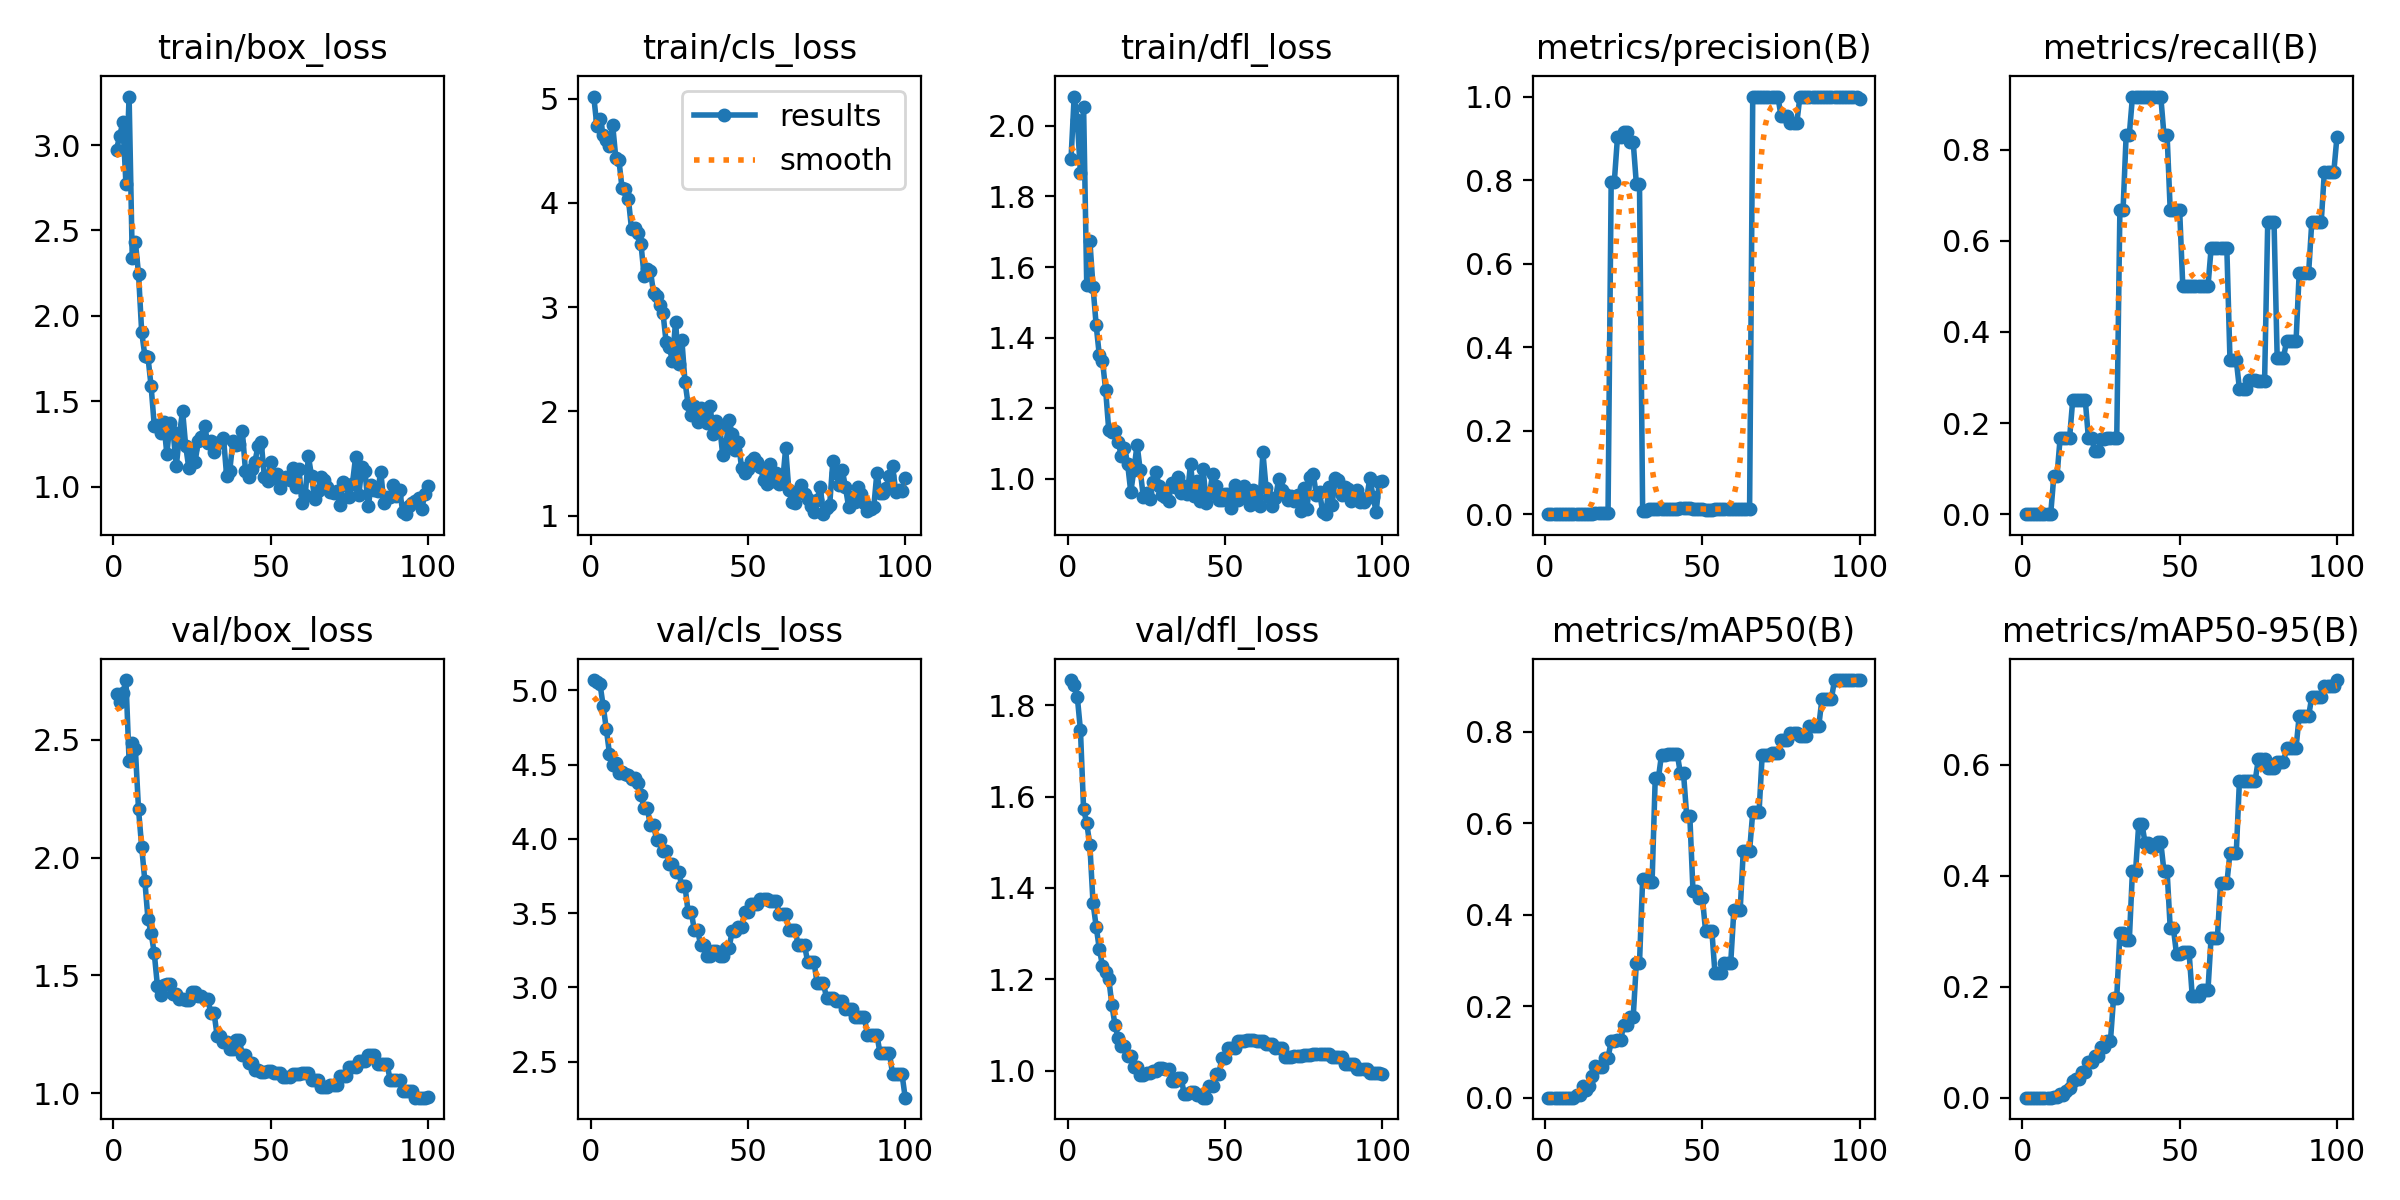

## 3. Inferencing trained custom model
After training, test trained model by inferencing sample image. Crop and save detected objects for data extraction.

In [ ]:
# Run command for inferencing
!yolo task=detect mode=predict model=runs/detect/train3/weights/best.pt source=datasets/license/images/orig/2.jpg show=True show_labels=True save_crop

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()
OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'

Ultralytics YOLOv8.1.0 🚀 Python-3.10.6 torch-2.1.2+cu118 CPU (AMD Ryzen 3 PRO 2100GE w/ Radeon Vega Graphics)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 D:\Download\FINAL-20240110T053915Z-001\FINAL\datasets\license\images\orig\2.jpg: 416x640 1 name, 1 code, 321.9ms
Speed: 5.0ms preprocess, 321.9ms inference, 0.0ms postprocess per image at shape (1, 3, 416, 640)
Results saved to runs\detect\predict16
💡 Learn more at https://docs.ultralytics.com/modes/predict


Ultralytics YOLOv8.1.0 🚀 Python-3.10.6 torch-2.1.2+cu118 CPU (AMD Ryzen 3 PRO 2100GE w/ Radeon Vega Graphics)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=config.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr


train: Scanning D:\Download\FINAL-20240110T053915Z-001\FINAL\datasets\license\labels\preprocess\train...:   0%|          | 0/8 [00:00<?, ?it/s]
train: Scanning D:\Download\FINAL-20240110T053915Z-001\FINAL\datasets\license\labels\preprocess\train... 0 images, 8 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<00:00, 266.74it/s]

val: Scanning D:\Download\FINAL-20240110T053915Z-001\FINAL\datasets\license\labels\preprocess\val...:   0%|          | 0/3 [00:00<?, ?it/s]
val: Scanning D:\Download\FINAL-20240110T053915Z-001\FINAL\datasets\license\labels\preprocess\val... 0 images, 3 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 427.09it/s]

  0%|          | 0/1 [00:00<?, ?it/s]
      1/100         0G          0      62.14          0          0        640:   0%|          | 0/1 [00:08<?, ?it/s]
      1/100         0G          0      62.14          0          0        640: 100%|██████████| 1/1 [00:08<00:00,  8.08s/it]
      1/100         0G          0      62.14          0      

__Image:__

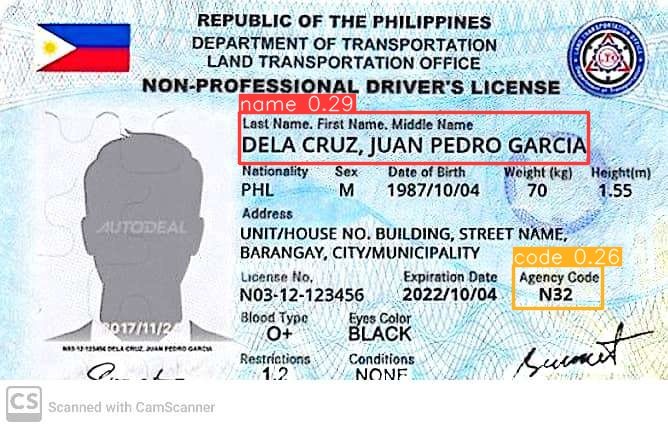

__Crops:__

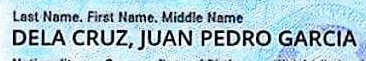

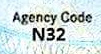

## 5. Extract data using OCR
Using a pretrained __EasyOCR__ model, extract the data from detected objects in the driver's license.

In [18]:
# Acquire all images from crops folder
root_folder = "runs/detect/predict16/crops"
image_files = []
for root, dirs, files in os.walk(root_folder):
    for file in files:
        # Check if the file has an image extension
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            # Construct the absolute path of the image file
            image_files.append(os.path.join(root, file))

image_files


['runs/detect/predict16/crops\\code\\2.jpg',
 'runs/detect/predict16/crops\\name\\2.jpg']

In [28]:
# Extract data using EasyOCR
reader = easyocr.Reader(['en'], gpu = False)

for x in image_files:
    result = reader.readtext(x)
    print(pd.DataFrame(result, columns=['bbox','text','conf']))

Using CPU. Note: This module is much faster with a GPU.


                                       bbox         text      conf
0    [[11, 9], [95, 9], [95, 27], [11, 27]]  Agency Codc  0.771448
1  [[28, 22], [70, 22], [70, 46], [28, 46]]          N32  0.897481
                                       bbox  \
0  [[11, 9], [247, 9], [247, 27], [11, 27]]   
1  [[8, 24], [358, 24], [358, 52], [8, 52]]   

                                 text      conf  
0  Last Nomc: First Home. Middle Meme  0.331994  
1        DELA CRUZ, JUAN PEDRO GARCIA  0.811597  
